In [9]:
import torch
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.interpolate import interp1d
from sklearn.metrics import  roc_curve, auc,precision_recall_curve,f1_score, confusion_matrix

In [10]:
gene="NPM1"
ROC_threshold=0.83
# gene="ITD"
# ROC_threshold=0.76
file_path=f"/home/weber50432/AML-WSI/MIL/test/{gene}_cell/2000_cells/different_K"
model_list= []
# check the model auc by the prediction_test.csv file, if the AUC less than 0.8, then the model is not good enough to use
for model in os.listdir(file_path):
    model_path=os.path.join(file_path,model)
    if not os.path.exists(os.path.join(model_path,"predictions_test.csv")):
        continue
    prediction_test=pd.read_csv(os.path.join(model_path,"predictions_test.csv"))
    fpr, tpr, thresholds = roc_curve(prediction_test['target'], prediction_test['probability'])
    roc_auc = auc(fpr, tpr)
    if roc_auc>ROC_threshold:
        model_list.append(model)
model_list.sort()
print(model_list)

['NPM1_densenet121_K24', 'NPM1_densenet121_K26']


In [11]:
loss_list = []
pred_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
for i in model_list:
    loaded_obj = torch.load(f"{file_path}/{i}/checkpoint_best.pth", map_location=torch.device('cpu'))
    loss_list.append(loaded_obj['best_acc'])
    pred_list.append(pd.read_csv(f"{file_path}/{i}/predictions_test.csv"))

In [12]:
weights_list= []
for i in loss_list:
  weights_list.append(np.exp(i))
weights_list=np.array(weights_list)
weights_list/=np.sum(weights_list)
print(weights_list)

[0.50833256 0.49166744]


In [13]:
# add the probability columns of the two models, and make the average. store to a new df
df_avg = pd.DataFrame()
df_avg['file'] = pred_list[0]['file']
df_avg['target'] =pred_list[0]['target']
df_avg['probability'] = 0

In [14]:

for index, i in enumerate(pred_list):
    df_avg['probability'] = df_avg['probability'] + i['probability']*weights_list[index]
# if the average probability is larger than 0.9, then the prediction is 1, otherwise 0
df_avg['prediction'] = df_avg['probability'].apply(lambda x: 1 if x > 0.5 else 0)
# switche the order of the columns, probability is the last column
df_avg = df_avg[['file', 'target', 'prediction', 'probability']]
df_avg.to_csv(f'{file_path}/{gene}_densenet121_K1/predictions_ensemble.csv', index=False)
df_avg

,file,target,prediction,probability
0,A360,1,1,1.000000
1,A742,0,1,0.556078
2,A460,0,1,0.975253
3,A782,0,0,0.084127
4,A732,0,1,0.863938
...,...,...,...,...
111,A165,1,1,0.999968
112,A239,0,1,0.916482
113,A1092,0,1,0.999395
114,A615,0,1,1.000000


Accuracy: 0.80
FPR at Sensitivity 0.75 is: 0.0938


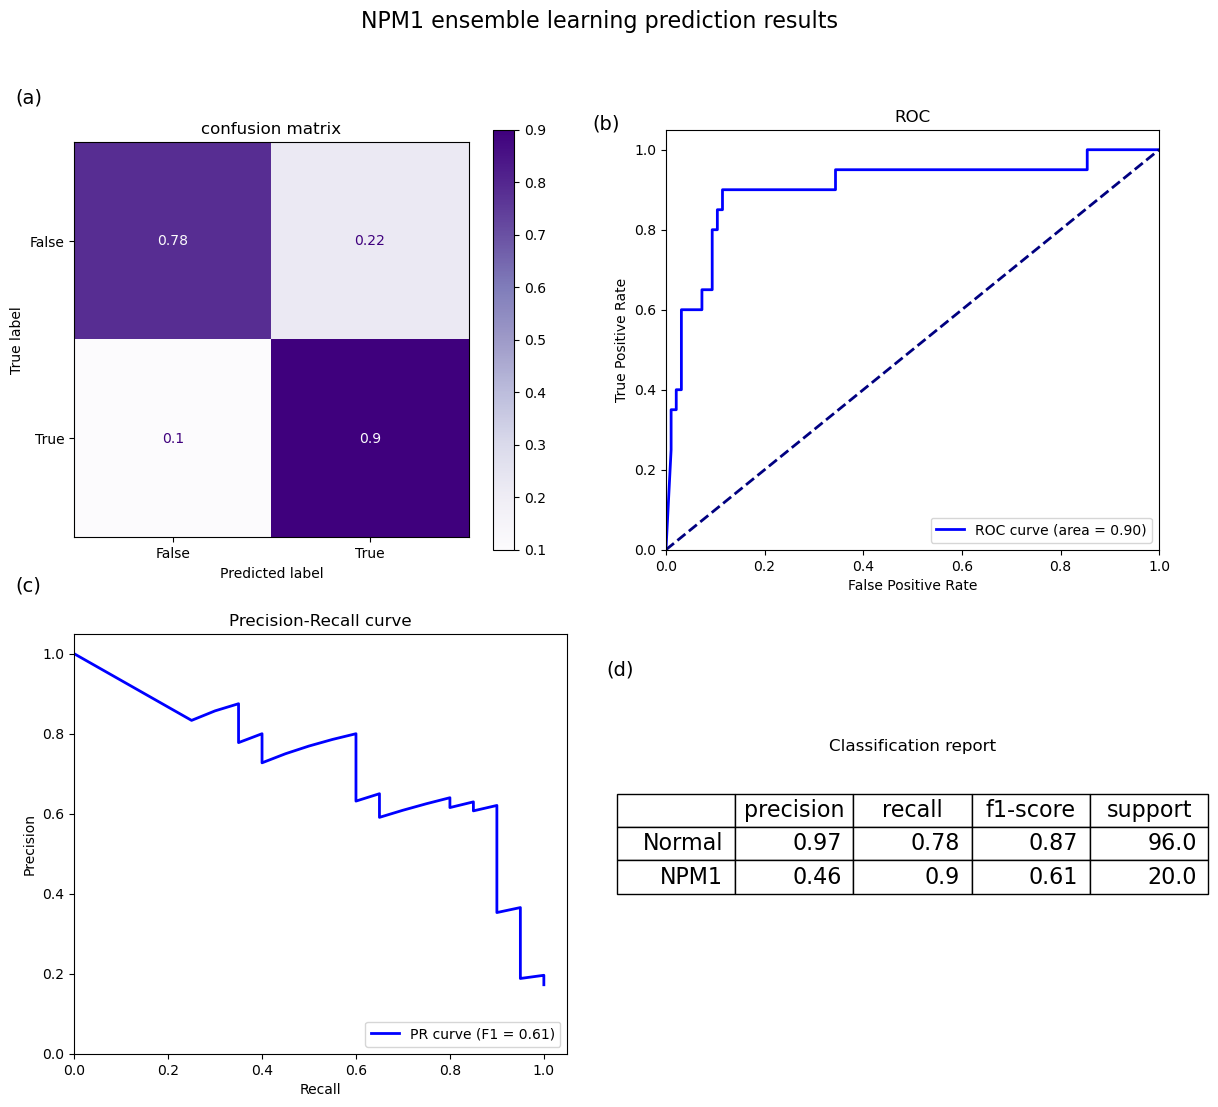

In [15]:
desired_sensitivity = 0.75
# Get the true labels and predicted labels
y_true = df_avg['target']
predicted_probabilities = df_avg["probability"]  # Replace with your predicted probabilities
true_labels = df_avg["target"]  # Replace with your true labels

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.001)
best_threshold = None
best_metric = 0.0
# Iterate over each threshold value
for threshold in thresholds:
    # Convert probabilities to predicted labels based on the threshold
    predicted_labels = (predicted_probabilities >= threshold).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    # Calculate the desired metric F1 score
    metric = f1_score(true_labels, predicted_labels)
    
    # Update the best threshold and metric if necessary
    if metric > best_metric:
        best_threshold = threshold
        best_metric = metric
cm = metrics.confusion_matrix(y_true, predicted_labels, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
# Compute the false positive rate, true positive rate and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predicted_probabilities)
# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)
# show the accuracy, precision, recall and f1-score
# print(metrics.classification_report(y_true, y_pred))
# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
# set the title of the figure
fig.suptitle('NPM1 ensemble learning prediction results', fontsize=16)
# Plot the confusion matrix in the first subplot
cm_display.plot(ax=axs[0][0], cmap=plt.cm.Purples)
axs[0][0].set_title('confusion matrix')
axs[0][0].text(-0.15, 1.1, '(a)', transform=axs[0][0].transAxes, size=14)
# Plot the ROC curve in the second subplot
axs[0][1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0][1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0][1].set_xlim([0.0, 1.0])
axs[0][1].set_ylim([0.0, 1.05])
axs[0][1].set_xlabel('False Positive Rate')
axs[0][1].set_ylabel('True Positive Rate')
axs[0][1].set_title('ROC')
axs[0][1].legend(loc="lower right")
axs[0][1].text(-0.15, 1, '(b)', transform=axs[0][1].transAxes, size=14)

# Plot the precision-recall curve in the third subplot
precision, recall, thresholds = precision_recall_curve(y_true, predicted_probabilities)
f1 = f1_score(y_true, predicted_labels)
axs[1][0].plot(recall, precision, color='blue', lw=2, label='PR curve (F1 = %0.2f)' % f1)
axs[1][0].set_xlim([0.0, 1.05])
axs[1][0].set_ylim([0.0, 1.05])
axs[1][0].set_xlabel('Recall')
axs[1][0].set_ylabel('Precision')
axs[1][0].text(-0.12, 1.1, '(c)', transform=axs[1][0].transAxes, size=14)
axs[1][0].legend(loc="lower right")
axs[1][0].set_title('Precision-Recall curve')
# show the accuracy, precision, recall and f1-score in a table form at the fourth subplot
report = metrics.classification_report(y_true, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.reset_index(drop=False, inplace=True)
df_report.rename(columns={'index':''}, inplace=True)
df_report.replace(to_replace="0", value='Normal', inplace=True)
df_report.replace(to_replace="1", value='NPM1', inplace=True)
accuracy = metrics.accuracy_score(y_true, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')
fpr_interp = interp1d(tpr, fpr)
desired_fpr = fpr_interp(desired_sensitivity)
print(f'FPR at Sensitivity {desired_sensitivity} is: {desired_fpr:.4f}')
# remove the last three rows
df_report.drop(df_report.tail(3).index, inplace=True)
df_report = df_report.round(2)
axs[1][1].text(-0.12,0.9, '(d)', transform=axs[1][1].transAxes, size=14)
axs[1][1].axis('tight')
axs[1][1].axis('off')
axs[1][1].set_title('Classification report', y=0.8,pad=-24)
# add the table
the_table = axs[1][1].table(cellText=df_report.values, colLabels=df_report.columns ,loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(1.2, 2)

# Show the plot
plt.show()


FPR at Sensitivity 0.75 at ensemble: 0.0938
FPR at Sensitivity 0.75 at NPM1_densenet121_K24: 0.1667
FPR at Sensitivity 0.75 at NPM1_densenet121_K26: 0.2396


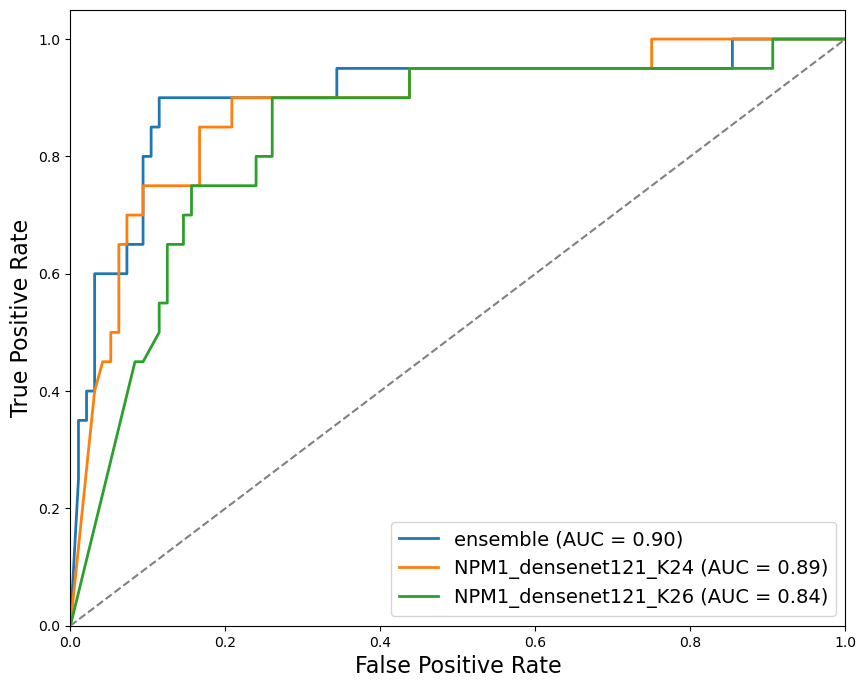

In [16]:
plt.figure(figsize=(10, 8))  # Set figure size

#Plot ensemble model
fpr, tpr, _ = roc_curve(df_avg['target'], df_avg['probability'])
roc_auc = auc(fpr, tpr)
fpr_interp = interp1d(tpr, fpr)
desired_fpr = fpr_interp(desired_sensitivity)
print(f'FPR at Sensitivity {desired_sensitivity} at ensemble: {desired_fpr:.4f}')
plt.plot(fpr, tpr, lw=2, label=f'ensemble (AUC = {roc_auc:.2f})')
for model in model_list:
    # Load the CSV file
    df = pd.read_csv(f"{file_path}/{model}/predictions_test.csv")
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(df['target'], df['probability'])
    roc_auc = auc(fpr, tpr)
    fpr_interp = interp1d(tpr, fpr)
    desired_fpr = fpr_interp(desired_sensitivity)
    print(f'FPR at Sensitivity {desired_sensitivity} at {model}: {desired_fpr:.4f}')
    plt.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(loc="lower right",fontsize=14)
# plt.savefig(f"./data/image/{gene}_ensemble.png", bbox_inches='tight', dpi=100)
plt.show()